In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numba import jit, float64

# Vizualize the attractor structure in 3D

using [Potree](http://potree.org/), a "WebGL based point cloud renderer for large point clouds"

In [2]:
@jit(float64[:](float64[:], float64), nopython=True)
def thomas_attractor(xyz, b):
    ''' ODE for Thomas attractor
        xyz: point position, 1d array, float64
        b: coefficient, float64
        
        use numba JIT
    '''
    sin_xyz = np.sin(xyz)
    dYdt = -b*xyz
    dYdt[0] += sin_xyz[1]
    dYdt[1] += sin_xyz[2]
    dYdt[2] += sin_xyz[0]
    return dYdt/np.sqrt(np.sum(dYdt**2))

In [3]:
def integrate(b):
    # burn
    y0 = np.random.randn(3)*3
    t_span = np.linspace(0, 100, 11)
    sol = odeint(lambda y, t: thomas_attractor(y, b),
                 y0, t_span)
    y0 = sol[-1, :]

    # solve
    t_span = np.linspace(0, 100, 7000)
    sol = odeint(lambda y, t: thomas_attractor(y, b),
                 y0, t_span)
    
    return sol

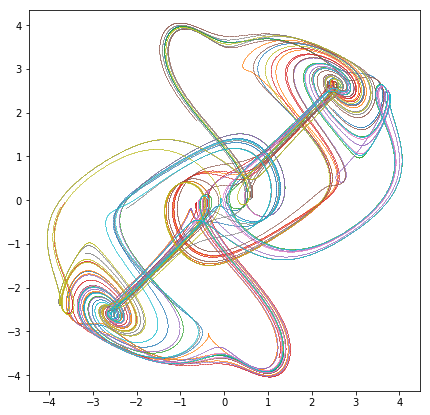

In [4]:
# test
b = 0.192

plt.figure(figsize=(7, 7));
plt.axis('equal');

for _ in range(10):
    sol = integrate(b)

    plt.plot(sol[:, 0], sol[:, 1], ',', alpha=0.5);

* Point cloud to 3D.

First approach is to directly use the points obtain from the solver as 3d point cloud. The problem with this approach is that the density of points is not uniform...

A second approach is to evaluate the density on a regular grid.

### Fill the cube

[sparse](https://sparse.pydata.org/en/latest/quickstart.html) library but not very usefull,
use Counter instead 

In [5]:
from collections import Counter
import matplotlib.cm as cm

In [17]:
# init
half_attractor_size = 4.2  # demi axe
nbr_pixel = 1000

cube = Counter()
len_cube = []

In [18]:
def tuplize(xyz):
    XYZ_px = ( (xyz + half_attractor_size)/(2*half_attractor_size) * nbr_pixel ).astype(int)
    XYZ_px = [tuple(ijk) for ijk in XYZ_px]
    return XYZ_px

In [35]:
# loop
for k in range(1000):
    xyz = integrate(b)

    cube.update(tuplize(xyz))
    
    len_cube.append(len(cube))

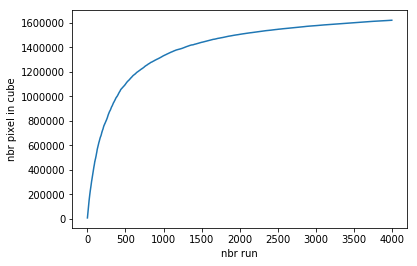

In [36]:
plt.plot(len_cube); plt.ylabel('nbr pixel in cube');
plt.xlabel('nbr run');

In [30]:
def color_convertor(value):
    return cm.jet(value, bytes=False)[:3]

In [31]:
max_count = cube.most_common()[0][1]
print(max_count)

274


In [32]:
textlines = []
for ijk, value in cube.items():
    if value<10:
        continue
    else:
        density = (value/max_count)*0.8 + 0.2
        xyz =  (np.array(ijk)/nbr_pixel - 0.5)*half_attractor_size*2
        to_str = [f'{u}' for u in np.hstack([xyz, color_convertor(density)])]
        textlines.append(' '.join(to_str) + '\n')    
        
print(len(textlines))

716941


In [33]:
print('1ere ligne')
print(textlines[0])

1ere ligne
-3.7296 0.0 1.4112000000000005 0.0 0.7705882352941177 1.0



In [34]:
# save .xyz file
with open(f'data/thomas_pointcloud_{nbr_pixel}.xyz', 'w') as f:
    f.writelines(textlines)

### PotreeConvertor

- Path to use     PotreeConverter:

        
        export PATH="~/Softwares/potree/PotreeConverter/master/build/PotreeConverter/:$PATH"

- command to convert:

    PotreeConverter -p --page-template ./page_template/ -i thomas_pointcloud.xyz
    
        PotreeConverter -f xyzrgb -color-range 1 -a RGB  -i thomas_pointcloud.xyz

![potree_v3_1000px.png](./potree_v3_1000px.png)

### Next:

- noise: https://core.ac.uk/download/pdf/34480918.pdf
- speed up? 